In [1]:
%load_ext autoreload
%autoreload 2

import os
import math
import time
import json
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from typing import Optional

from context_compression.data import DataLoaderLite
from context_compression.model import GPT, GPTConfig
from context_compression.attn import AttentionKind, ProtectionKind, SelectionHeadLinearComboKind

device_id = -1
assert torch.cuda.is_available(), "come on man. we need cuda"
device = "cuda"

enc = tiktoken.get_encoding("gpt2")


In [2]:
class DataLoaderWrapper:
    def __init__(self, B, T, process_rank, num_processes, split, use_hf_style_inputs=False):
        self.loader = DataLoaderLite(B, T, process_rank, num_processes, split, use_hf_style_inputs)
        self.loader.reset()  # ensure the internal state is initialized

    def __iter__(self):
        return self

    def __next__(self):
        # next_batch is expected to return a batch (or, if desired, you could
        # add a stopping condition to eventually raise StopIteration).
        return self.loader.next_batch()

dataloader = DataLoaderWrapper(B=2, T=64, process_rank=0, num_processes=1, split="train",use_hf_style_inputs=True)

In [3]:
from mup.coord_check import get_coord_data,plot_coord_data
from mup import set_base_shapes

def lazy_model_inner(width):
    head_dim = 64
    seq_len = 64
    assert width % head_dim == 0, "width must be divisible by 64"
    config = GPTConfig(
        n_head=width // head_dim,
        head_dim=head_dim,
        n_embd=width,
        block_size=seq_len,
        n_layer=12,
        disable_selection=True,
        epsilon=0.0, # mup doesn't work with regularization
        use_hf_style_inputs=True,
        attention_kind=AttentionKind.SELECTIVE,
        for_inference=False,
        mup=True,
        query_zero_init=True,
        readout_zero_init=True,
        l1_loss=True,
    )
    return GPT(config).cuda()

base_model = lazy_model_inner(64)
delta_model = lazy_model_inner(128)

In [4]:
def lazy_model(width):
    def inner():
        model = set_base_shapes(lazy_model_inner(width),base_model,delta=delta_model,rescale_params=False)
        model.apply(model._init_weights)
        return model
    return inner

models = {64: lazy_model(64), 128: lazy_model(128), 256: lazy_model(256), 512: lazy_model(512), 64*12: lazy_model(64*12), 1024: lazy_model(1024)}

df = get_coord_data(models,dataloader,dict_in_out=True,output_name="loss")

# plot_coord_data(df) # the plot takes up too much screen real estate

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


In [5]:
# for k in list(models.keys()):
#     if k != 64:
#         del models[k]


In [6]:
# import debugpy
# debugpy.listen(5678)
# print("Debugpy listening on port 5678. Now is the time to attach!")
# debugpy.wait_for_client()


In [7]:
# ok let's implement this ourselves!
from functools import partial


train_loader = DataLoaderWrapper(B=2, T=64, process_rank=0, num_processes=1, split="train",use_hf_style_inputs=True)

def train(train_loader,model,max_steps,grad_accum_steps=1):

    model.cuda()
    
    optimizer = model.configure_optimizers(weight_decay=0, learning_rate=1e-3, device_type="cuda")

    stat_arrays = {'loss': [], 'l1_loss': []}


    step_num = 0
    micro_step_num = 0

    model.train()
    start_time = time.time()

    for batch in train_loader:
        batch = {k: v.cuda() for k, v in batch.items()}

        if micro_step_num % grad_accum_steps == 0:
            if step_num > max_steps:
                break

            optimizer.zero_grad()


            # let's register our hookso
            def hook(module, input, output, key):
                with torch.no_grad():
                    if type(output) == tuple:
                        output = output[0]
                    
                    if stat_arrays.get(key) is None:
                        stat_arrays[key] = []
                    stat_arrays[key].append(output.abs().mean().item())

            coord_check_handles = []
            for module_name, module in model.named_modules():
                if module_name == 'transformer.wte':
                    coord_check_handles.append(module.register_forward_hook(partial(hook, key='token_embedding')))
                elif module_name.endswith('.attn'):
                    coord_check_handles.append(module.register_forward_hook(partial(hook, key='attn')))
                elif module_name.endswith('.mlp'):
                    coord_check_handles.append(module.register_forward_hook(partial(hook, key='mlp')))
                elif module_name == 'lm_head':
                    coord_check_handles.append(module.register_forward_hook(partial(hook, key='lm_head')))
                    

        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            output_dict = model(**batch)
            loss = output_dict['loss']

        loss = loss / grad_accum_steps
        loss.backward()
        stat_arrays['loss'].append(loss.item())
        stat_arrays['l1_loss'].append(output_dict['losses']['l1'].item())

        with torch.no_grad():
            l1_loss = 0
            # let's just consider the weight-decayed weights for now
            weight_decay_param_groups = [p for p in optimizer.param_groups if p.get('weight_decay', 0) > 0]
            for group in weight_decay_param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        l1_loss += p.grad.abs().mean().item()
            stat_arrays['l1_loss'].append(l1_loss)
                    

        micro_step_num += 1
        if micro_step_num % grad_accum_steps == 0:
            optimizer.step()

            for handle in coord_check_handles:
                handle.remove()
            
            step_num += 1

    assert micro_step_num % grad_accum_steps == 0 # make sure our dataloader didn't run out at an inopportune time

    print("latest inits:",model.get_latest_inits())
    print("model.config:",model.config)
    print("model l1 loss:",model.l1_loss().item())
    print("time per step:",(time.time()-start_time)/step_num)
    for param_group in optimizer.param_groups:
        print("param group lr:",param_group['lr'],'param group weight decay:',param_group.get('weight_decay',None),'num params:',sum(p.numel() for p in param_group['params']))
    
    import debugpy
    debugpy.breakpoint()

    return {k: torch.tensor(v).view(step_num, -1).mean(dim=1) for k, v in stat_arrays.items()}

from tqdm import tqdm
def get_coord_data(train_loader,models,max_steps,grad_accum_steps=1):
    stat_arrays = {}

    for model in tqdm(models.values()):
        out_dict = train(train_loader,model(),max_steps,grad_accum_steps)
        for key, value in out_dict.items():
            if stat_arrays.get(key) is None:
                stat_arrays[key] = []
            stat_arrays[key].append(value)

    return stat_arrays

# micro_out_dict = train(train_loader,models[64](),3)
# micro_out_dict

max_steps = 10
out_dict = get_coord_data(train_loader,models,max_steps)


  0%|          | 0/6 [00:00<?, ?it/s]

num decayed parameter tensors: 50, with 3,810,368 parameters
num non-decayed parameter tensors: 98, with 10,112 parameters
num low-lr selection head parameter tensors: 0, with 0 parameters
using fused AdamW: True
optim_groups inputted into config_cls:
raw param group lr: 0.001 raw param group weight decay: 0 num params: 3810368
raw param group lr: 0.001 raw param group weight decay: 0.0 num params: 10112
raw param group lr: 0.001 raw param group weight decay: 0.0 num params: 0


 17%|█▋        | 1/6 [00:00<00:02,  2.08it/s]

latest inits: [{'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 192), InfDim(64, 64)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 64), InfDim(64, 64)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 256), InfDim(64, 64)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 64), InfDim(256, 256)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 192), InfDim(64, 64)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 64), InfDim(64, 64)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 256), InfDim(64, 64)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 64), InfDim(256, 256)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 192), InfDim(64, 64)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 64), InfDim(64, 64)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 256), InfDim(64,

 33%|███▎      | 2/6 [00:00<00:01,  2.31it/s]

latest inits: [{'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 384), InfDim(64, 128)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 128), InfDim(64, 128)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 512), InfDim(64, 128)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 128), InfDim(256, 512)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 384), InfDim(64, 128)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 128), InfDim(64, 128)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 512), InfDim(64, 128)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 128), InfDim(256, 512)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 384), InfDim(64, 128)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 128), InfDim(64, 128)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 512

 50%|█████     | 3/6 [00:01<00:01,  2.04it/s]

latest inits: [{'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 768), InfDim(64, 256)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 256), InfDim(64, 256)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 1024), InfDim(64, 256)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 256), InfDim(256, 1024)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 768), InfDim(64, 256)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 256), InfDim(64, 256)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 1024), InfDim(64, 256)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 256), InfDim(256, 1024)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 768), InfDim(64, 256)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 256), InfDim(64, 256)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256,

 67%|██████▋   | 4/6 [00:02<00:01,  1.45it/s]

latest inits: [{'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 1536), InfDim(64, 512)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 512), InfDim(64, 512)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 2048), InfDim(64, 512)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 512), InfDim(256, 2048)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 1536), InfDim(64, 512)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 512), InfDim(64, 512)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 2048), InfDim(64, 512)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 512), InfDim(256, 2048)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 1536), InfDim(64, 512)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 512), InfDim(64, 512)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(2

 83%|████████▎ | 5/6 [00:04<00:01,  1.02s/it]

latest inits: [{'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 2304), InfDim(64, 768)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 768), InfDim(64, 768)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 3072), InfDim(64, 768)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 768), InfDim(256, 3072)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 2304), InfDim(64, 768)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 768), InfDim(64, 768)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 3072), InfDim(64, 768)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 768), InfDim(256, 3072)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 2304), InfDim(64, 768)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 768), InfDim(64, 768)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(2

100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

latest inits: [{'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 3072), InfDim(64, 1024)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 1024), InfDim(64, 1024)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 4096), InfDim(64, 1024)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 1024), InfDim(256, 4096)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 3072), InfDim(64, 1024)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 1024), InfDim(64, 1024)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(256, 4096), InfDim(64, 1024)])}, {'std': 0.004082482904638631, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 1024), InfDim(256, 4096)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(192, 3072), InfDim(64, 1024)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfShape([InfDim(64, 1024), InfDim(64, 1024)])}, {'std': 0.02, 'kind': 'mup', 'infshape': InfSh

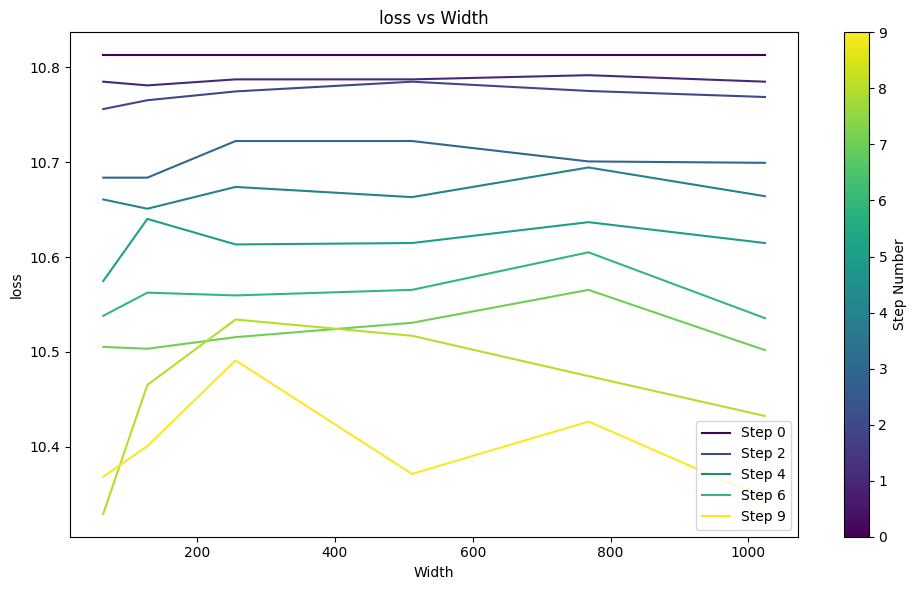

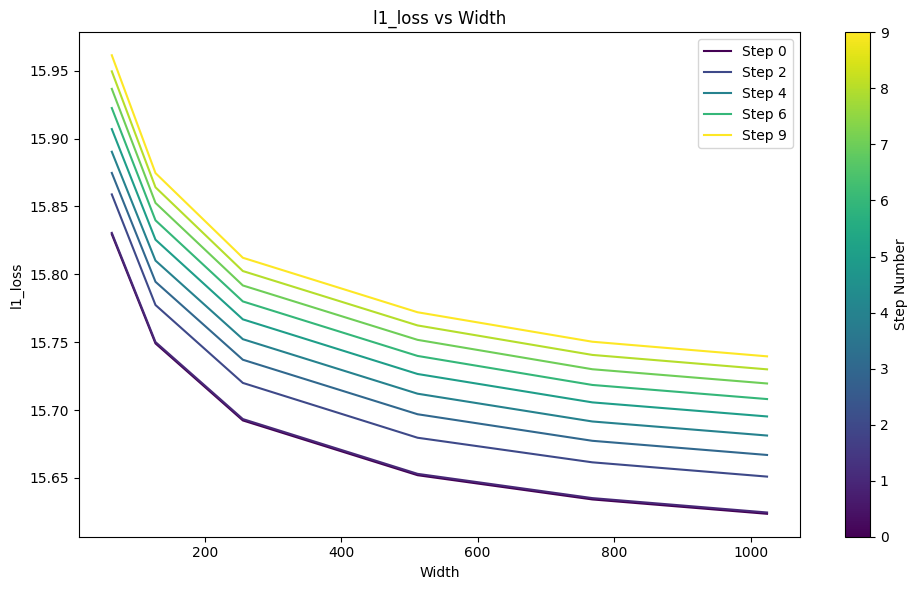

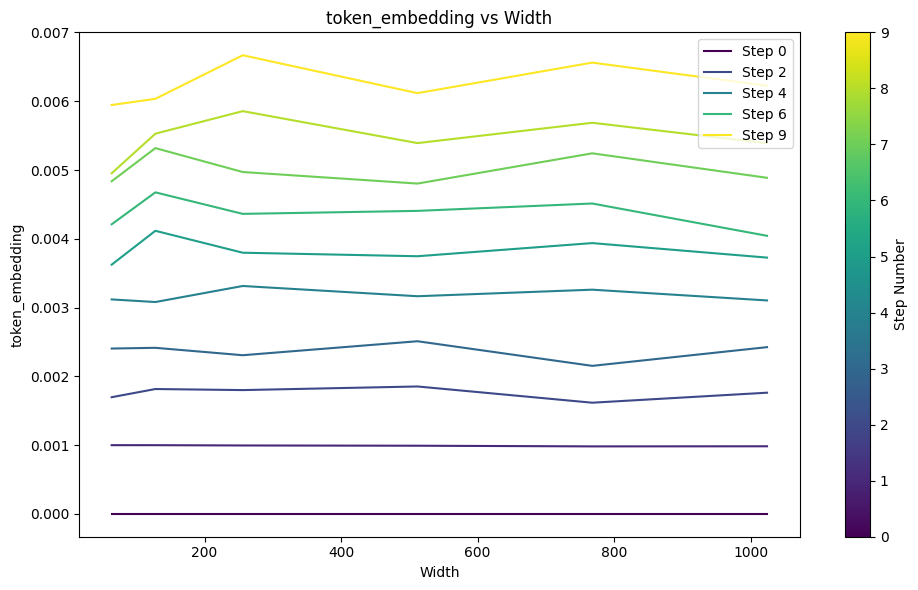

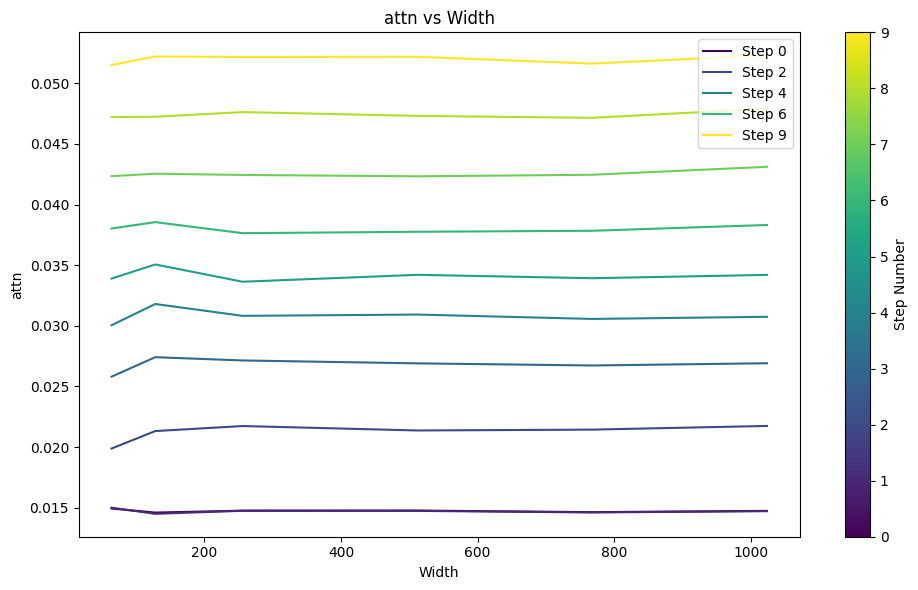

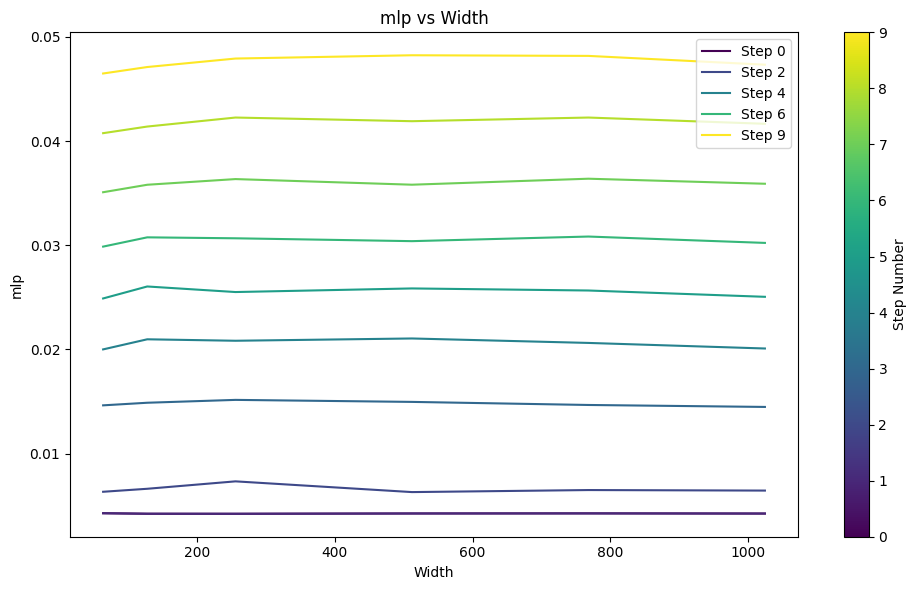

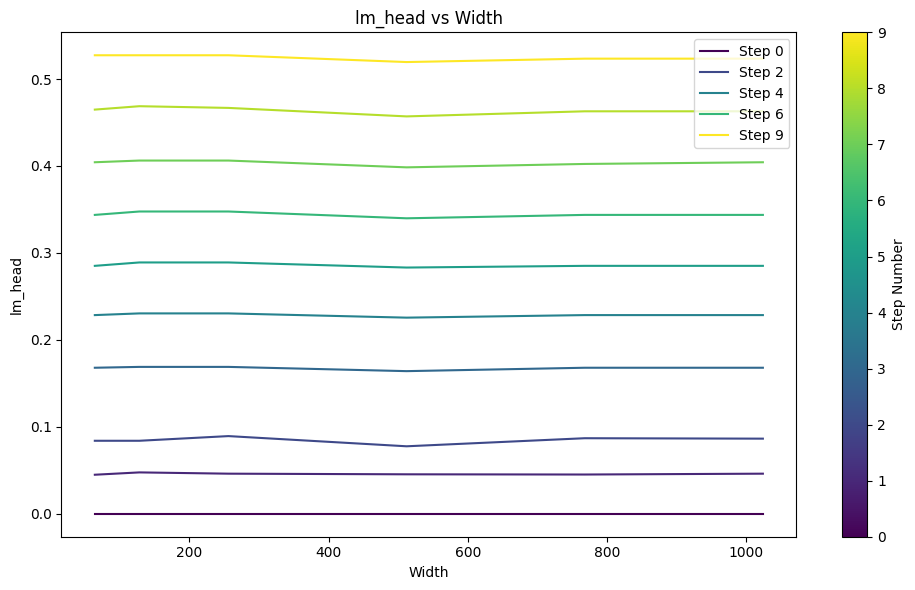

In [8]:
out_dict
{k: torch.stack(v).shape for k, v in out_dict.items()} # shape (num_widths, num_steps)

widths = list(models.keys())
step_nums = range(max_steps)

# plot one graph per key
# that graph should be:
# x axis: width
# y axis: numeric value
# one line per step, color-coded by step number (from blue=0 -> red=max_steps-1)
import matplotlib.pyplot as plt
import numpy as np

for key in out_dict.keys():
    fig, ax = plt.figure(figsize=(10, 6)), plt.gca()
    
    # Create a colormap for the steps
    cmap = plt.cm.viridis
    norm = plt.Normalize(0, max_steps-1)
    
    for step_num in step_nums:
        values = [out_dict[key][i][step_num].item() for i in range(len(widths))]
        ax.plot(widths, values, label=f'Step {step_num}', color=cmap(norm(step_num)))
    
    plt.xlabel('Width')
    plt.ylabel(key)
    plt.title(f'{key} vs Width')
    
    # Only show a few steps in the legend to avoid overcrowding
    if max_steps > 5:
        handles, labels = ax.get_legend_handles_labels()
        selected_indices = np.linspace(0, max_steps-1, 5, dtype=int)
        ax.legend([handles[i] for i in selected_indices], [labels[i] for i in selected_indices])
    else:
        ax.legend()
    
    # Create a proper colorbar with the correct mappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # You need to set an array for the mappable
    plt.colorbar(sm, ax=ax, label='Step Number')
    
    plt.tight_layout()
    plt.show()


In [9]:
# print out, for all the weights, the latest_init (if it exists)
# models[64]().print_latest_init()